# Simulation of "Distributed Control of Micro-Storage Devices with Mean Field Games, Antonio De Paola, 2016"

## 0. Load Data and Define Parameters

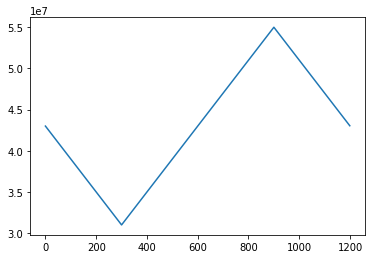

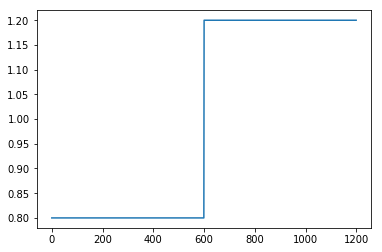

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import time as time
#Time
T = 24

#Number of ESS Users
N = 1000000

#Interval between time slots 
delta_t = 0.02

#Interval between state slots
delta_S = 0.004

#Inflexible demand. Approximate of Figure 1
D_i = np.zeros(shape = (int(T/delta_t)))
'''for i in range(len(D_i)):
    if (i*delta_t < 5):
        D_i[i] = (30 - i*delta_t) * 1000000
    elif (i*delta_t < 10):
        D_i[i] = (4*i*delta_t + 5) * 1000000
    elif (i*delta_t < 15):
        D_i[i] = 45 * 1000000
    elif (i*delta_t < 18):
        D_i[i] = (10*i*delta_t/3 - 5) * 1000000
    else:
        D_i[i] = (130 - 25*i*delta_t/6) * 1000000'''

for i in range(len(D_i)):
    if (i*delta_t < 6):
        D_i[i] = (43-2*i*delta_t) * 1000000
    elif (i*delta_t < 18):
        D_i[i] = (19+2*i*delta_t) * 1000000
    else:
        D_i[i] = (91-2*i*delta_t) * 1000000




plt.figure(1)
plt.plot(D_i)
plt.show()

#Quadratic loss coefficient
gamma = 2.5

#Maximum energy of ESS
E_r = 20

#Maximum power of ESS
P_r = 2

#Epsilon for checking convergence of price
e_p = 0.1

#Epsilon for checking convergence of distribution
e_D = 1000

#Epsilon for updating distribution
e = 0.1

#Sigma for calculating initial distribution
sigma = 1.2

#Coefficient of final cost function
c = 100000

#Coefficient of price
k = np.ones(int(T/delta_t))
for i in range(len(k)):
    if i<len(k)/2:
        k[i] = 0.8
    else:
        k[i] = 1.2
plt.figure(12323)
plt.plot(k)
plt.show()

## 1. Define Simulator

In [3]:
class MFG_Calculator:
    
    def __init__(self, T, N, delta_t, delta_S, D_i, gamma, E_r, P_r, e_p, e_D, e, sigma, c, k):
        
        #Save Input Variables
        self.T = T
        self.N = N
        self.delta_t = delta_t
        self.delta_S = delta_S
        self.D_i = copy.copy(D_i)
        self.gamma = gamma
        self.E_r = E_r
        self.P_r = P_r
        self.e_p = e_p
        self.e_D = e_D
        self.e = e
        self.sigma = sigma
        self.c = c
        self.k = copy.copy(k)
        print("Save Input Variables")
        
        #Define Additional Variables in Class
        self.numslot_t = int(T/delta_t) #Number of time slot
        self.numslot_S = int(1/delta_S) #Number of state slot
        self.D_s = np.zeros(shape = (self.numslot_t)) #Flexible demand
        self.D = copy.copy(D_i) #Total demand = Inflexible demand + Flexible demand
        self.r_min = -P_r/E_r #Minimum of charging rate
        self.r_max = P_r/E_r #Maximum of charging rate
        self.E_tot = N * E_r #Aggregated energy capacity
        self.m_0 = np.zeros(shape = (self.numslot_S)) #Initial distribution of ESS
        self.m = np.zeros(shape = (self.numslot_t, self.numslot_S)) #Distribution of ESS
        self.r = np.zeros(shape = (self.numslot_t, self.numslot_S)) #Optimal charging rate
        self.p = np.zeros(shape = (self.numslot_t)) #Energy price
        
        self.state = np.zeros(shape = (self.numslot_S)) #State slot
        
        for j in range(self.numslot_S):
            self.state[j] = j*self.delta_S
        print("Define Additional Variables in Class")
        
        #Define Variables for Simulation
        self.m_old = np.zeros(shape = (self.numslot_t, self.numslot_S)) #Old distribution of ESS
        self.m_new = np.zeros(shape = (self.numslot_t, self.numslot_S)) #Updated distribution of ESS
        self.D_s_old = np.zeros(shape = (self.numslot_t)) #Old flexible demand of ESS
        self.D_s_new = np.zeros(shape = (self.numslot_t)) #Updated flexible demand of ESS
        self.p_old = np.zeros(shape = (self.numslot_t)) #Old price
        self.p_new = np.zeros(shape = (self.numslot_t)) #Updated price
        self.r_old = np.zeros(shape = (self.numslot_t, self.numslot_S)) #Old optimal charging rate
        self.r_new = np.zeros(shape = (self.numslot_t, self.numslot_S)) #Updated optimal charging rate
        self.V_new = np.zeros(shape = (self.numslot_t, self.numslot_S)) #Updated value function
        print("Define Variables for Simulation")
        
        #Calculate initial distribution
        self.Calculate_Initial_Distribution()
        print("Calculate Initial Distribution of ESS")
        
        #Calculate end value function
        
        
        
        #Calculate initial price
        for i in range(self.numslot_t):
            self.p[i] = self.Calculate_Energy_Price(self.m_0, self.r[i], i)
        print("Initial distribution of ESS")
        plt.figure(12)
        plt.plot(self.state, self.m_0)
        plt.show()
        print("Initial price")
        plt.figure(123)
        plt.plot(self.p)
        plt.show()
        
        
        
    def Calculate_Initial_Distribution(self): #Calculate initial distribution of ESS, which is following N(0.5,sigma^2), return nothing
        #Set m_0
        m_0 = np.zeros(shape = (self.numslot_S))
        total = 0
        for j in range(self.numslot_S):
            m_0[j] = np.exp(-((j+0.5)*self.delta_S-0.5)*((j+0.5)*self.delta_S-0.5)/(2*self.sigma*self.sigma)) / (2*np.pi*self.sigma*self.sigma)
            total = total + m_0[j]
        for j in range(self.numslot_S):
            m_0[j] = m_0[j] / total
            self.m_0[j] = m_0[j]
        
        return
        
    def Calculate_End_Value_Function(self):
        for j in range(self.numslot_S):
            self.V_new[self.numslot_t-1,j] = self.c * ((j+0.5) * self.delta_S - 0.5) * ((j+0.5) * self.delta_S - 0.5)
        return
        
        
    def Calculate_Energy_Price(self, m, r, i): #Calculate energy price for given distribution and charging rate, return energy price vector
        D = self.D_i[i]
        p = 0
        for j in range(self.numslot_S): #Calculate total demand
            D = D + self.E_tot*m[j]*(r[j]+self.gamma*r[j]*r[j])
        #Approximate of Figure 2
        if D < 40000000:
            p = 1.25*D/1000000 - 10
        else:
            p = (43*D*D)/(1000000*1000000*40) - (339*D)/(1000000*4)+1710
        
        
        #Implement Here!
        
        
        
        
        return p*self.k[i]
        
        
        
    def Calculate_Final_Cost(self, S): #Calculate final cost when final charing level of ESS is S, return final cost
        answer = self.c * (S-0.5) * (S-0.5)
        return answer
    
    
    #Simulation part
    
    
    
    def Start_Simulation(self): #Main function of simulation
        asdfasdf = time.time()
        self.Initialize_Distribution() #Initialize distribution of ESS, step 1
        r = np.zeros(shape = (self.numslot_S)) #For initializing energy price in small iteration
        itr1 = 0
        print("Start Simulation")
        while (True): 
            print("Start " + str(itr1) + "th big iteration")
            self.Calculate_End_Value_Function()
            for i in range(self.numslot_t):
                self.p_old[i] = self.Calculate_Energy_Price(self.m_0, r, i) #Initial energy price always comes from only inflexible demand for every small iteration, step 2-a
            for i in reversed(range(self.numslot_t)):
                #print("Start small iteration when time is " + str(i*self.delta_t))
                itr2 = 0
                while(True):
                    #print("Start " + str(itr2) + "th small iteration when time is " + str(i*self.delta_t))
                    self.Calculate_Optimal_Charging_Rate(i)
                    #plt.figure(333)
                    #plt.plot(self.state,self.r_new[i])
                    #plt.show()
                    self.p_new[i] = self.Calculate_Energy_Price(self.m_old[i], self.r_new[i], i)
                    #print("The old price is " + str(self.p_old[i]))
                    #print("The new price is " + str(self.p_new[i]))
                    #print("The difference between them is " + str(abs(self.p_old[i]-self.p_new[i])))
                    if (self.Check_Convergence_of_Energy_Price(i)):
                        self.Update_Value_Function(i-1)
                        #plt.figure(333)
                        #plt.plot(self.state,self.r_new[i])
                        #plt.show()
                        #plt.figure(22222)
                        #plt.plot(self.state, self.V_new[i])
                        #plt.show()
                        break
                    else:
                        if (itr2 >= 50 ):
                            self.Calculate_Suboptimal_Charging_Rate(i)
                            self.p_old[i] = self.Calculate_Energy_Price(self.m_old[i], self.r_new[i], i)
                            #print("THE ITERATION DOES NOT CONVERGE, SO WE TAKE SUBOPTIMAL")
                            #plt.figure(333)
                            #plt.plot(self.state,self.r_new[i])
                            #plt.show()
                            if (itr2 >= 200 and itr2%200==0):
                                self.Calculate_Heuristic_Optimal_Charging_Rate(i)
                                self.p_old[i] = self.Calculate_Energy_Price(self.m_old[i], self.r_new[i], i)
                                if (itr2 == 400):
                                    self.Calculate_Heuristic_Optimal_Charging_Rate2(i)
                                    self.p_old[i] = self.Calculate_Energy_Price(self.m_old[i], self.r_new[i], i)
                        itr2 = itr2 + 1
            self.Calculate_New_Distribution() #Calculate new distribution of ESS, step 3
            print("Calculate new distribution of ESS")
            self.Calculate_New_Flexible_Demand() #Calculate new flexible demand, step 3
            print("Calculate new flexible demand")
            Difference = 0
            plt.figure(989)
            plt.plot(self.D_s_new)
            plt.show()
            for i in range(self.numslot_t):
                Difference = Difference + abs(self.D_s_new[i]-self.D_s_old[i])*self.delta_t
            print("The difference between flexible demand is " + str(Difference))
            if (Difference < self.e_D): #Check the convergence of flexible demand, step 4
                print("The flexible demand converges, so big iteration terminates")
                break
            else:
                for i in range(self.numslot_t):
                    self.D_s_old[i] = self.D_s_new[i]
                    for j in range(self.numslot_S):
                        self.m_old[i,j] = self.m_new[i,j]
                itr1 = itr1 + 1
        #Input the result, step 5
        for i in range(self.numslot_t):
            self.D_s[i] = self.D_s_old[i]
            self.D[i] = self.D_i[i] + self.D_s[i]
            for j in range(self.numslot_S):
                self.r[i,j] = self.r_new[i,j]
                self.m[i,j] = self.m_old[i,j]
            self.p[i] = self.Calculate_Energy_Price(self.m[i], self.r[i], i)
        print("Simulation ends")
        end = time.time()
        print("Total time is "+str(end - asdfasdf))
        return
    
    
    def Initialize_Distribution(self): #Initialize distribution, return nothing
        for i in range(self.numslot_t):
            for j in range(self.numslot_S):
                self.m_old[i,j] = self.m_0[j]
        return
    
    
    def Calculate_Optimal_Charging_Rate(self, i): #Calculate optimal charging rate and value function given old energy price, return nothing
        for j in range(self.numslot_S):
            if (j == 0):
                r = (self.p_old[i]+(self.V_new[i,j+1]-self.V_new[i,j])/self.delta_S) / (-2*self.gamma*self.p_old[i])
                if (r > self.r_max):
                    r = self.r_max
                elif (r < 0):
                    r = 0
                self.r_new[i,j] = r    
            elif (j == self.numslot_S-1):
                r = (self.p_old[i]+(self.V_new[i,j]-self.V_new[i,j-1])/self.delta_S) / (-2*self.gamma*self.p_old[i])
                if (r > 0):
                    r = 0
                elif (r < self.r_min):
                    r = self.r_min
                self.r_new[i,j] = r
            else:
                r = (self.p_old[i]+(self.V_new[i,j+1]-self.V_new[i,j-1])/(2*self.delta_S)) / (-2*self.gamma*self.p_old[i])
                if (r > self.r_max):
                    r = self.r_max
                elif (r < self.r_min):
                    r = self.r_min
                self.r_new[i,j] = r
        return
        
        
    def Calculate_Suboptimal_Charging_Rate(self, i): #Calculate suboptimal charging rate when there are too many iterations
        r = np.zeros(shape=(self.numslot_S))
        #dif = 0
        for j in range(self.numslot_S):
            if (j == 0):
                r[j] = (self.p_old[i]+(self.V_new[i,j+1]-self.V_new[i,j])/self.delta_S) / (-2*self.gamma*self.p_old[i])
                if (r[j] > self.r_max):
                    r[j] = self.r_max
                elif (r[j] < 0):
                    r[j] = 0    
            elif (j == self.numslot_S-1):
                r[j] = (self.p_old[i]+(self.V_new[i,j]-self.V_new[i,j-1])/self.delta_S) / (-2*self.gamma*self.p_old[i])
                if (r[j] > 0):
                    r[j] = 0
                elif (r[j] < self.r_min):
                    r[j] = self.r_min
            else:
                r[j] = (self.p_old[i]+(self.V_new[i,j+1]-self.V_new[i,j-1])/(2*self.delta_S)) / (-2*self.gamma*self.p_old[i])
                if (r[j] > self.r_max):
                    r[j] = self.r_max
                elif (r[j] < self.r_min):
                    r[j] = self.r_min
            #dif = dif + abs(self.r_new[i,j]-r[j])
            self.r_new[i, j] = (self.r_new[i,j]+r[j]) / 2
        #print('The difference between r is '+str(dif))
        return
    
    
    def Calculate_Heuristic_Optimal_Charging_Rate(self, i):
        for j in range(self.numslot_S):
            self.r_new[i,j] = (self.r_new[i+1,j]+self.r_new[i,j]) / 2
        return
    
    
    def Calculate_Heuristic_Optimal_Charging_Rate2(self, i):
        self.r_new[i] = copy.copy(self.r_new[i+1])
        return
    
    
    
    def Update_Value_Function(self, i):
        for j in range(self.numslot_S):
            delta_V = 0
            if (self.r_new[i+1,j] > 0):
                delta_V = self.delta_t * self.r_new[i+1,j] * (self.V_new[i+1,j+1]-self.V_new[i+1,j]) / self.delta_S
            elif (self.r_new[i+1,j] < 0):
                delta_V = self.delta_t * self.r_new[i+1,j] * (self.V_new[i+1,j]-self.V_new[i+1,j-1]) / self.delta_S
            delta_V = delta_V + self.delta_t*self.p_old[i+1]*(self.r_new[i+1,j]+self.gamma*self.r_new[i+1,j]*self.r_new[i+1,j])
            self.V_new[i,j] = self.V_new[i+1,j] + delta_V
        return
    
    
    def Check_Convergence_of_Energy_Price(self, i): #Check whether energy price converges or not. If converges, return True. If not converge, update data and return False
        if (abs(self.p_old[i]-self.p_new[i]) < self.e_p):
            return True
        else:
            self.p_old[i] = self.p_new[i]
            return False
    
    
    def Calculate_New_Distribution(self): #Calculate new distribution of ESS, return nothing
        for i in range(self.numslot_t):
            whole_sum = 0
            for j in range(self.numslot_S):
                if (i == 0):
                    self.m_new[i,j] = self.m_0[j]
                else:
                    if (j == 0):
                        self.m_new[i,j] = self.m_new[i-1,j] - self.delta_t*(self.r_new[i-1,j+1]*self.m_new[i-1,j+1]-self.r_new[i-1,j]*self.m_new[i-1,j])/self.delta_S + self.e*(self.m_new[i-1,j+1]-self.m_new[i-1,j])
                    elif (j == self.numslot_S-1):
                        self.m_new[i,j] = self.m_new[i-1,j] - self.delta_t*(self.r_new[i-1,j]*self.m_new[i-1,j]-self.r_new[i-1,j-1]*self.m_new[i-1,j-1])/self.delta_S + self.e*(self.m_new[i-1,j-1]-self.m_new[i-1,j])
                    else:
                        self.m_new[i,j] = self.m_new[i-1,j] - self.delta_t*(self.r_new[i-1,j+1]*self.m_new[i-1,j+1]-self.r_new[i-1,j-1]*self.m_new[i-1,j-1])*0.5/self.delta_S + self.e*(self.m_new[i-1,j+1]-2*self.m_new[i-1,j]+self.m_new[i-1,j-1])
                whole_sum = whole_sum + self.m_new[i,j]
            for j in range(self.numslot_S):
                self.m_new[i,j] = self.m_new[i,j]/whole_sum
            
        return
    
    
    def Calculate_New_Flexible_Demand(self): #Calculate new flexible demand, return nothing
        for i in range(self.numslot_t):
            self.D_s_new[i] = 0
            for j in range(self.numslot_S):
                self.D_s_new[i] = self.D_s_new[i] + self.E_tot*self.m_new[i,j]*(self.r_new[i,j]+self.gamma*self.r_new[i,j]*self.r_new[i,j])
        return
    
    
    def Check_Convergence_of_Flexible_Demand(self): #Check whether flexible demand converges or not. If converges, return True. If not converge, update data and return False
        Difference = 0
        for i in range(self.numslot_t):
            Difference = Difference + abs(self.D_s_new[i]-self.D_s_old[i])*self.delta_t
        if (Difference < self.e_D):
            return True
        else:
            for i in range(self.numslot_t):
                self.D_s_old[i] = self.D_s_new[i]
                for j in range(self.numslot_S):
                    self.m_old[i,j] = self.m_new[i,j]
            return False
    
    
    
    
    
    

## 2. Main Function

Save Input Variables
Define Additional Variables in Class
Define Variables for Simulation
Calculate Initial Distribution of ESS
Initial distribution of ESS


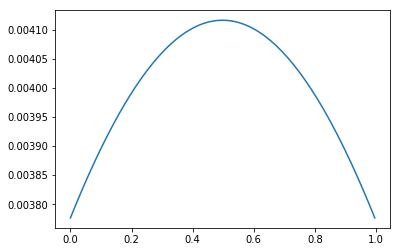

Initial price


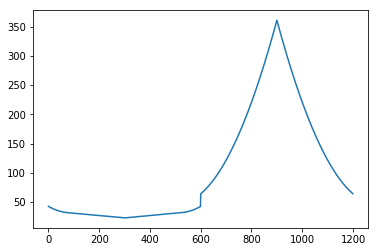

Start Simulation
Start 0th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


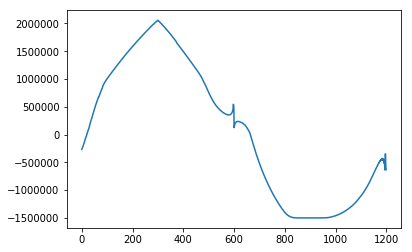

The difference between flexible demand is 26605557.270846706
Start 1th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


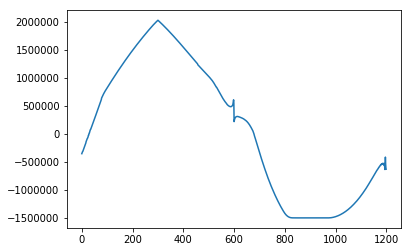

The difference between flexible demand is 1995076.682947218
Start 2th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


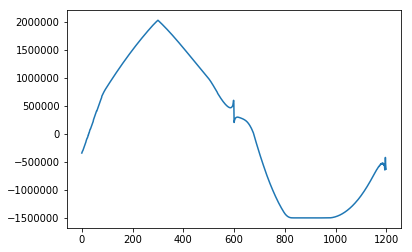

The difference between flexible demand is 279265.87195444974
Start 3th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


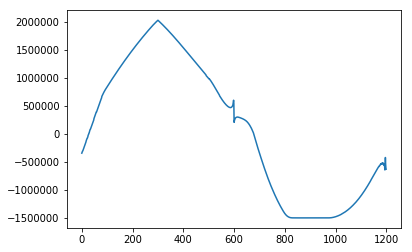

The difference between flexible demand is 53358.058694907326
Start 4th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


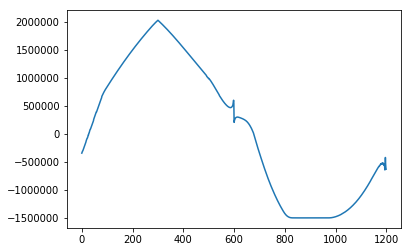

The difference between flexible demand is 10398.431964931238
Start 5th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


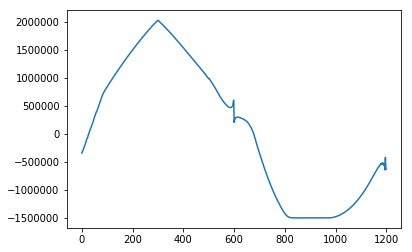

The difference between flexible demand is 1655.3507899673473
Start 6th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


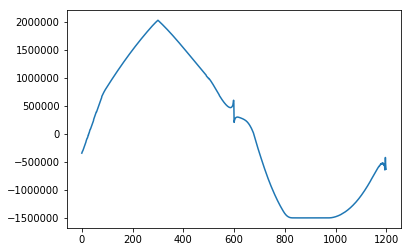

The difference between flexible demand is 261.68576303840587
The flexible demand converges, so big iteration terminates
Simulation ends
Total time is 51.223920583724976


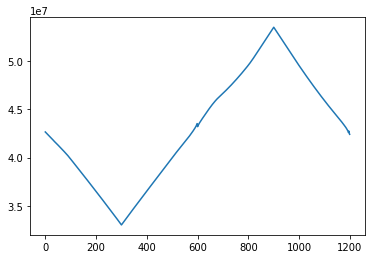

Original cost is 123611370.192
New cost is 105747078.29818928
maximum is 53500205.17738416 when time is 18.0


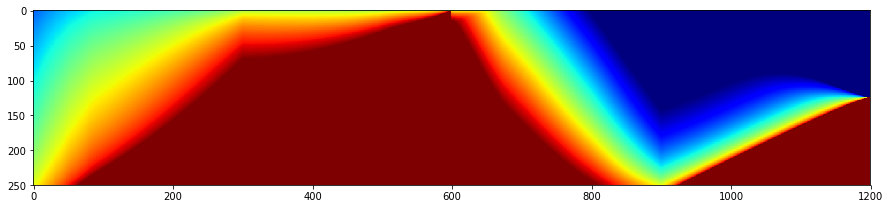

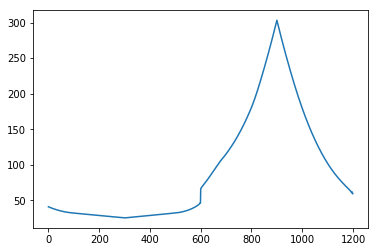

In [4]:
Test = MFG_Calculator(T, N, delta_t, delta_S, D_i, gamma, E_r, P_r, e_p, e_D, e, sigma, c, k)
Test.Start_Simulation()


Printing = np.zeros(shape=(Test.numslot_t))
for i in range(Test.numslot_t):
    Printing[i]=Test.D_i[i]+Test.D_s_old[i]
plt.figure(89)
plt.plot(Printing)
plt.show()

cost = 0
p = np.zeros(shape=(len(D_i)))
for i in range(len(D_i)):
    D = D_i[i]
    if D < 40000000:
        p[i] = 1.25*D/1000000 - 10
    else:
        p[i] = (43*D*D)/(1000000*1000000*40) - (339*D)/(1000000*4)+1710
for i in range(len(D_i)):
    cost = cost + delta_t*D_i[i]*p[i]*k[i]/1000
print("Original cost is "+str(cost))
profit = 0
for i in range(Test.numslot_t):
    profit = profit + Test.delta_t*Test.p[i]*Test.D[i]/1000
print("New cost is "+ str(profit))

max=0
index=0
for i in range(Test.numslot_t):
    if max<Test.D[i]:
        max=Test.D[i]
        index=i
print("maximum is "+str(max)+" when time is "+str(index*Test.delta_t))

data = np.transpose(Test.r)
data_real=np.zeros(shape=(Test.numslot_S, Test.numslot_t))
for i in range(Test.numslot_S):
    for j in range(Test.numslot_t):
        data_real[i,j] = data[Test.numslot_S-i-1,j]
fig, ax = plt.subplots(figsize=(15,24))
im = ax.imshow(data_real, cmap='jet')
plt.show()
plt.figure(23112)
plt.plot(Test.p)
plt.show()

# 4. Nothing

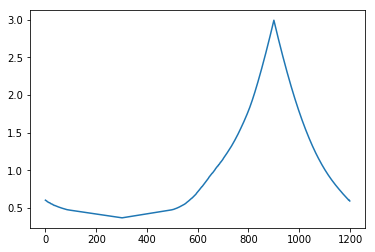

Save Input Variables
Define Additional Variables in Class
Define Variables for Simulation
Calculate Initial Distribution of ESS
Initial distribution of ESS


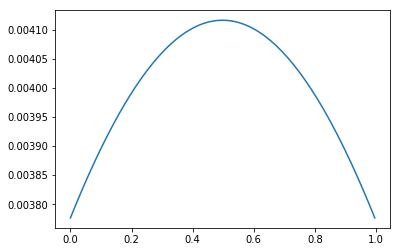

Initial price


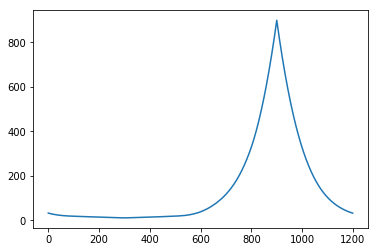

Start Simulation
Start 0th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


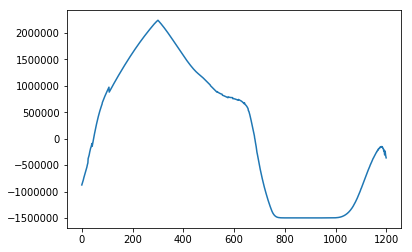

The difference between flexible demand is 28553771.661115985
Start 1th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


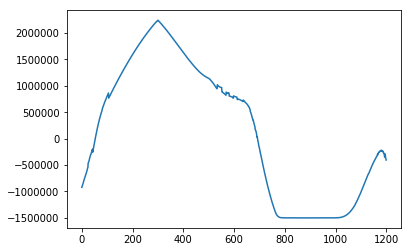

The difference between flexible demand is 1421978.7881037965
Start 2th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


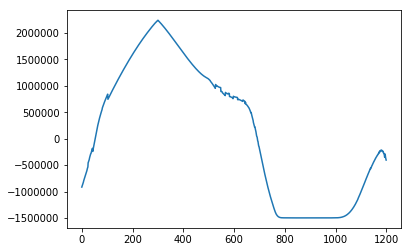

The difference between flexible demand is 158627.98664306302
Start 3th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


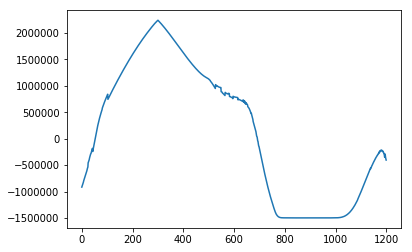

The difference between flexible demand is 23724.636576647146
Start 4th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


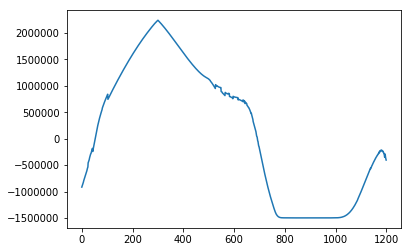

The difference between flexible demand is 6882.004275667864
Start 5th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


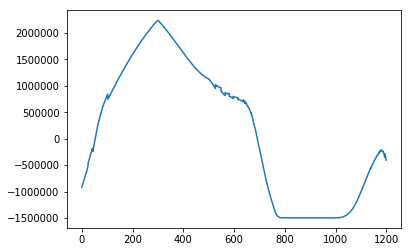

The difference between flexible demand is 2575.4549658376345
Start 6th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


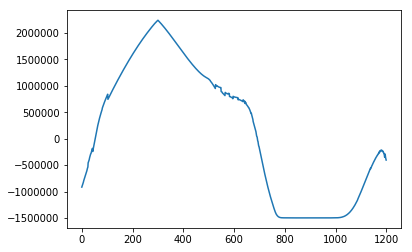

The difference between flexible demand is 1825.1902890330125
Start 7th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


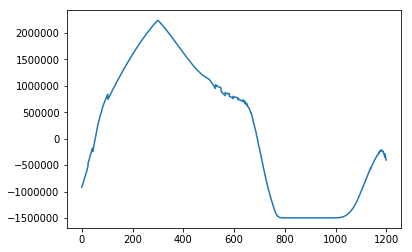

The difference between flexible demand is 2462.3590784573275
Start 8th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


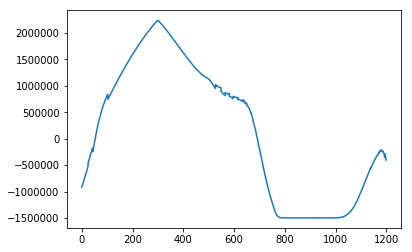

The difference between flexible demand is 3355.06436367935
Start 9th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


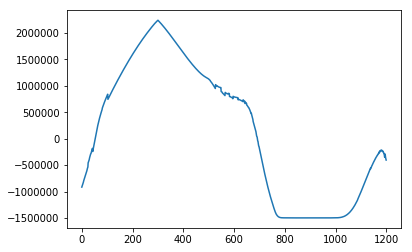

The difference between flexible demand is 2020.822736293989
Start 10th big iteration
Calculate new distribution of ESS
Calculate new flexible demand


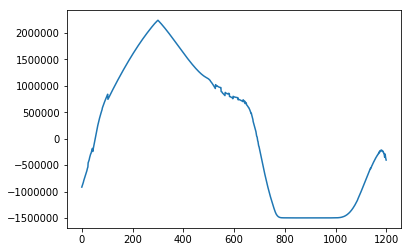

The difference between flexible demand is 953.2328342756431
The flexible demand converges, so big iteration terminates
Simulation ends
Total time is 57.85632562637329


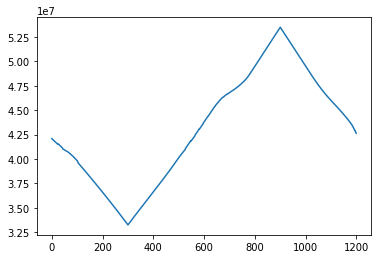

Original cost is 108570745.49999999
New cost is 150881326.1240733
maximum is 53500055.992322676 when time is 18.0


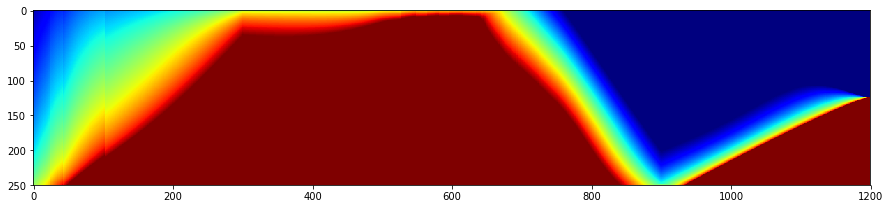

In [19]:
k2=np.zeros(shape=(Test.numslot_t))
sum=0
for i in range(len(Test.p)):
    sum = sum + Test.p[i]
sum = sum / len(Test.p)
for i in range(len(k)):
    k2[i] = Test.p[i] / sum
plt.figure(2132312)
plt.plot(k2)
plt.show()
Test2 = MFG_Calculator(T, N, delta_t, delta_S, D_i, gamma, E_r, P_r, e_p, e_D, e, sigma, c, k2)
Test2.Start_Simulation()




Printing2 = np.zeros(shape=(Test2.numslot_t))
for i in range(Test2.numslot_t):
    Printing2[i]=Test2.D_i[i]+Test2.D_s_old[i]
plt.figure(89)
plt.plot(Printing2)
plt.show()

cost2 = 0
p = np.zeros(shape=(len(D_i)))
for i in range(len(D_i)):
    D = D_i[i]
    if D < 40000000:
        p[i] = 1.25*D/1000000 - 10
    else:
        p[i] = (43*D*D)/(1000000*1000000*40) - (339*D)/(1000000*4)+1710
for i in range(len(D_i)):
    cost2 = cost2 + delta_t*D_i[i]*p[i]*k2[i]/1000
print("Original cost is "+str(cost2))
profit2 = 0
for i in range(Test2.numslot_t):
    profit2 = profit2 + Test2.delta_t*Test2.p[i]*Test2.D[i]/1000
print("New cost is "+ str(profit2))

max2=0
index2=0
for i in range(Test2.numslot_t):
    if max2<Test2.D[i]:
        max2=Test2.D[i]
        index2=i
print("maximum is "+str(max2)+" when time is "+str(index2*Test2.delta_t))

data2 = np.transpose(Test2.r)
data2_real=np.zeros(shape=(Test2.numslot_S, Test2.numslot_t))
for i in range(Test2.numslot_S):
    for j in range(Test2.numslot_t):
        data2_real[i,j] = data2[Test2.numslot_S-i-1,j]
fig2, ax2 = plt.subplots(figsize=(15,24))
im2 = ax2.imshow(data2_real, cmap='jet')
plt.show()

In [20]:
print(cost2)

181942939.56664312


In [ ]:
for i in range(Test.numslot_t):
    print("When time is "+str(i*Test.delta_t))
    plt.figure(23232)
    plt.plot(Test.m[i])
    plt.show()

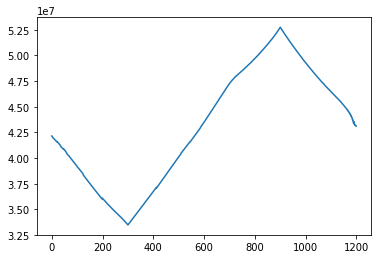

In [373]:
Printing = np.zeros(shape=(Test.numslot_t))
for i in range(Test.numslot_t):
    Printing[i]=Printing[i]+Test.D_i[i]+Test.D_s_old[i]
plt.figure(89)
plt.plot(Printing)
plt.show()

In [29]:
profit = 0
for i in range(Test.numslot_t):
    profit = profit + Test.delta_t*Test.p[i]*Test.D[i]/1000
print(profit)

93433278.3552571


In [343]:
price = np.zeros(shape=(Test.numslot_t))
for i in range(Test.numslot_t):
    if Printing[i] < 40000000:
        price[i] = 1.25*Printing[i]/1000000 - 10
    else:
        price[i] = (43*Printing[i]*Printing[i])/(1000000*1000000*40) - (339*Printing[i])/(1000000*4)+1710
profit=0
for i in range(Test.numslot_t):
    profit = profit + Test.delta_t*Printing[i]*price[i]/1000
print(profit)

94287671.76815441


In [30]:
max=0
index=0
for i in range(Test.numslot_t):
    if max<Test.D[i]:
        max=Test.D[i]
        index=i
print("maximum is "+str(max)+" when time is "+str(index*Test.delta_t))


maximum is 52753112.295384794 when time is 18.0


In [29]:
a=np.array([1,2])
print(a)
class te:
    
    def __init__(self, a):
        self.a=np.zeros(shape=(2))
        self.a[0]=a[0]
        self.a[1]=a[1]
        return
    def gogo(self):
        self.a[1]=33
        return
    
    
t=te(a)
t.gogo()
print(a)

[1 2]
[1 2]


In [257]:
if(1==1  2==2):
    print(123)

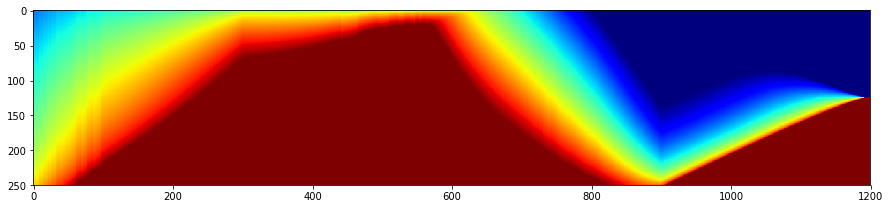

In [220]:
data = np.transpose(Test.r)
data_real=np.zeros(shape=(Test.numslot_S, Test.numslot_t))
for i in range(Test.numslot_S):
    for j in range(Test.numslot_t):
        data_real[i,j] = data[Test.numslot_S-i-1,j]
fig, ax = plt.subplots(figsize=(15,24))

im = ax.imshow(data_real, cmap='jet')
plt.show()

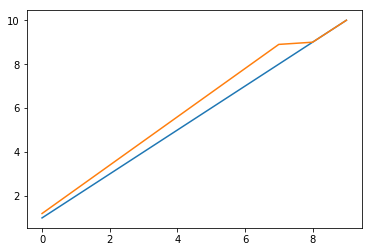

In [59]:
a=np.array([1,2,3,4,5,6,7,8,9,10])
b=np.array([1.2,2.3,3.4,4.5,5.6,6.7,7.8,8.9,9,10])
plt.plot(a)
plt.plot(b)
plt.show()